## Chapter 3: Linear Regression - Applied Exercises

In [89]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

# Specific to the textbook ISLP
from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize, poly

8. This question involves the use of simple linear regression on the Auto data set.

Use the `sm.OLS()` function to perform a simple linear regression with `mpg` as the response and horsepower as the predictor. Use the `summarize()` function to print the results. Comment on the output.

In [90]:
Auto = load_data('Auto')
Auto.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')

In [91]:
# Creat the design matrix matrix, define the predictor and response
design = MS(['horsepower'])
X = pd.DataFrame({
    'intercept': np.ones(Auto.shape[0]),
    'horsepower': Auto['horsepower']
})

y = Auto['mpg']

In [92]:
# Define and fit the model
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Fri, 18 Aug 2023   Prob (F-statistic):           7.03e-81
Time:                        10:40:59   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a statistically significant relationship between `horsepower` and `mpg`. The model predicts that for every increase of 1hp, there's a drop of about -0.16 mpg. 

What is the predicted mpg associated with a horsepower of
98? What are the associated 95% confdence and prediction
intervals?

In [93]:
newX = pd.DataFrame({
    'intercept': [1],
    'horsepower': [98]
})

newX

,intercept,horsepower
0,1,98


In [94]:
# Compute predictions at newX:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([24.46707715])

In [95]:
# Compute confidence intervals
new_predictions.conf_int(alpha=0.05)

array([[23.97307896, 24.96107534]])

In [96]:
# Compute prediction intervals
new_predictions.conf_int(obs=True, alpha=0.05)

array([[14.80939607, 34.12475823]])

Plot the response and the predictor in a new set of axes ax. Use
the ax.axline() method or the abline() function defned in the lab to display the least squares regression line.

In [97]:
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

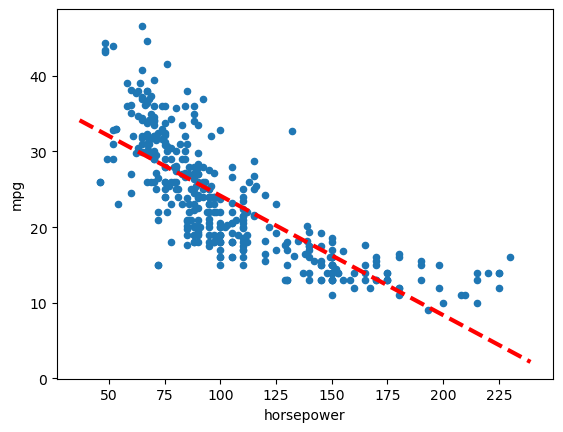

In [98]:
ax = Auto.plot.scatter('horsepower', 'mpg')
abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)

In [99]:
# Create a residual plot
def residual_plot(results, *args, **kwargs):
    "Create a residual plot for the results"
    ax = subplots(figsize=(8,8))[1]
    ax.scatter(results.fittedvalues , results.resid, *args, **kwargs)
    ax.set_xlabel('Fitted value')
    ax.set_ylabel('Residual')
    ax.axhline(0, c='k', ls='--');

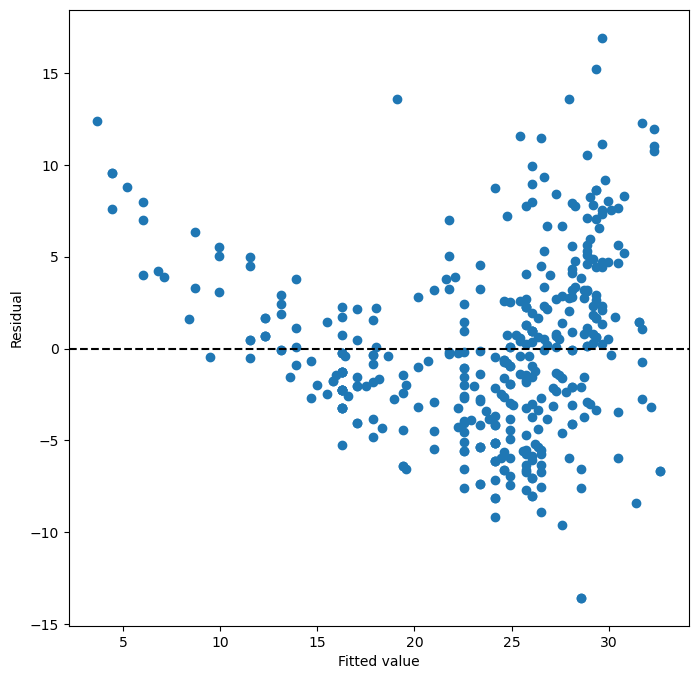

In [100]:
residual_plot(results)

The residual plot has quite a distinct funnel shape, indicating heteroscedasticity (non-constant variance) in the residuals, meaning that the relationship probably isn't linear.

In [115]:
def leverage_plot(results, *args, **kwargs):
    "Plot the leverage of each datapoint in the predictor"
    infl = results.get_influence()
    ax = subplots(figsize=(8,8))[1]
    ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag, *args, **kwargs)
    ax.set_xlabel('Index')
    ax.set_ylabel('Leverage')
    print('Point with max leverage: ', np.argmax(infl.hat_matrix_diag))

Point with max leverage:  115


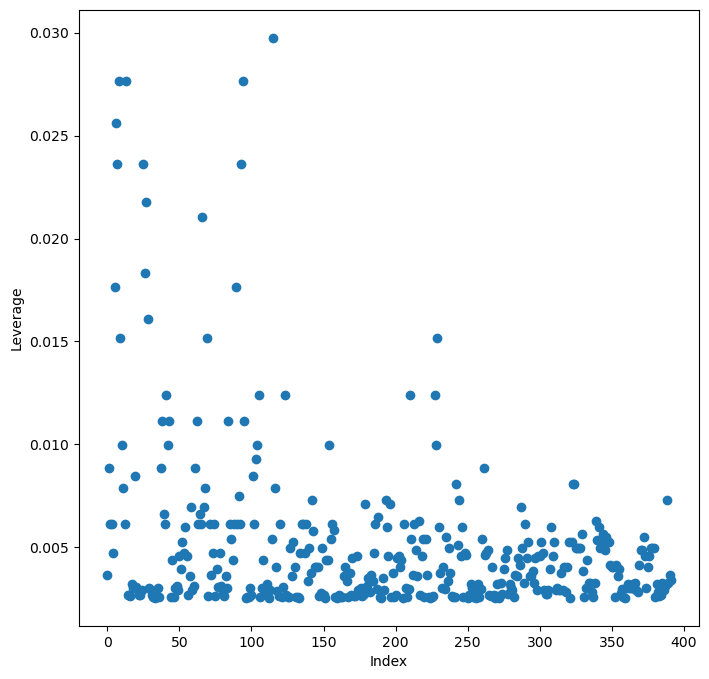

In [116]:
leverage_plot(results)

9. This question involves the use of multiple linear regression on the Auto data set.

Produce a scatterplot matrix which includes all of the variables
in the data set.

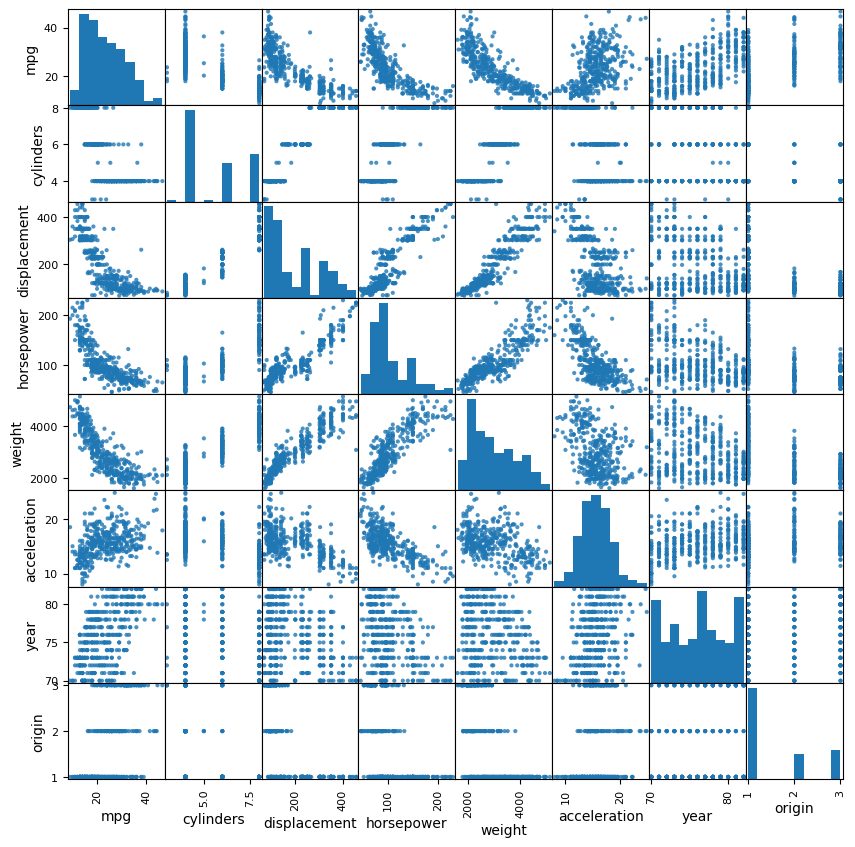

In [103]:
scatter_matrix(Auto, alpha=0.8, figsize=(10, 10), diagonal='hist')
plt.show()

Compute the matrix of correlations between the variables using
the DataFrame.corr() method.

In [104]:
# Remove names since this is a string column
Auto_no_names = Auto.columns.drop('name')

In [105]:
Auto_no_names

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin'],
      dtype='object')

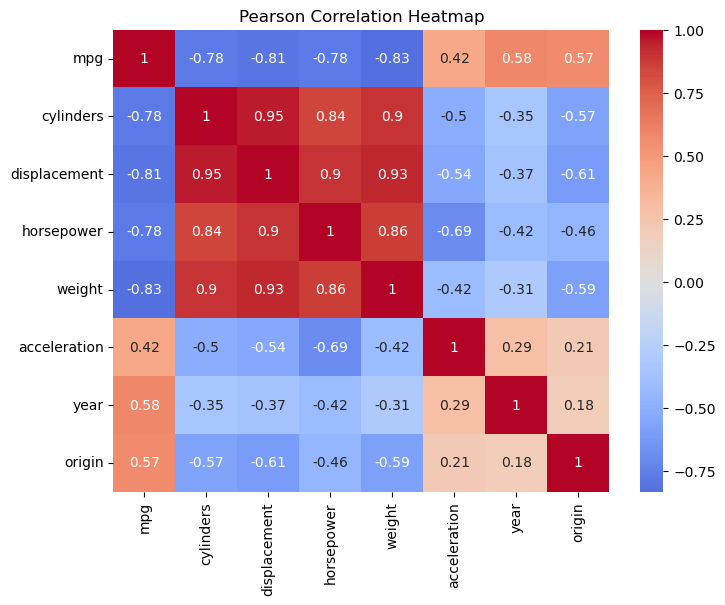

In [106]:
# Calculate Pearson correlation coefficients
correlation_matrix = Auto[Auto_no_names].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson Correlation Heatmap')
plt.show()

We see a block of linearly correlated variables around cylinders, displacement, horsepower and weight, all of which have something to do with the size of the engine/vehicle, which we'd probably expect.

Use the `sm.OLS()` function to perform a multiple linear regression with `mpg` as the response and all other variables except `name` as the predictors. Use the `summarize()` function to print the results. Comment on the output.

In [107]:
minus_name = Auto.columns.drop(['mpg', 'name'])
Xmn = MS(minus_name).fit_transform(Auto)
model1 = sm.OLS(y, Xmn)
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Fri, 18 Aug 2023   Prob (F-statistic):          2.04e-139
Time:                        10:43:35   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept      -17.2184      4.644     -3.707      0.000     -26.350      -8.087
cylinders       -0.4934      0.323     -1.526      0.128      -1.129       0.142
displacement     0.0199      0.008      2.647      0.008       0.005       0.035
horsepower      -0.0170      0.014     -1.230      0.220      -0.044       0.010
weight          -0.0065      0.001     -9.929      0.000      -0.008      -0.005
acceleration     0.0806      0.099      0.815      0.415      -0.114       0.275
year             0.7508      0.051     14.729      0.000       0.651       0.851
origin           1.4261      0.278      5.127      0.000       0.879       1.973
==============================================================================
Omnibus:                       31.906   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.100
Skew:                           0.529   Prob(JB):                     2.95e-12
Kurtosis:                       4.460   Cond. No.                     8.59e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Is there a relationship between the predictors and the response?

In [108]:
anova_lm(results, results1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,390.0,9385.915872,0.0,NaN,NaN,NaN
1,384.0,4252.212530,6.0,5133.703341,77.267308,5.376746e-63


`displacement`, `weight`, `year` and `origin` all appear to have statistically significant correlations.

The coefficient for the `year` variable suggest an increase of 0.75hp for every year, i.e. if `year` is year of manufacture, cars are becoming more powerful over time.

Produce some of diagnostic plots of the linear regression fit as
described in the lab. Comment on any problems you see with the
fit. Do the residual plots suggest any unusually large outliers?
Does the leverage plot identify any observations with unusually
high leverage?

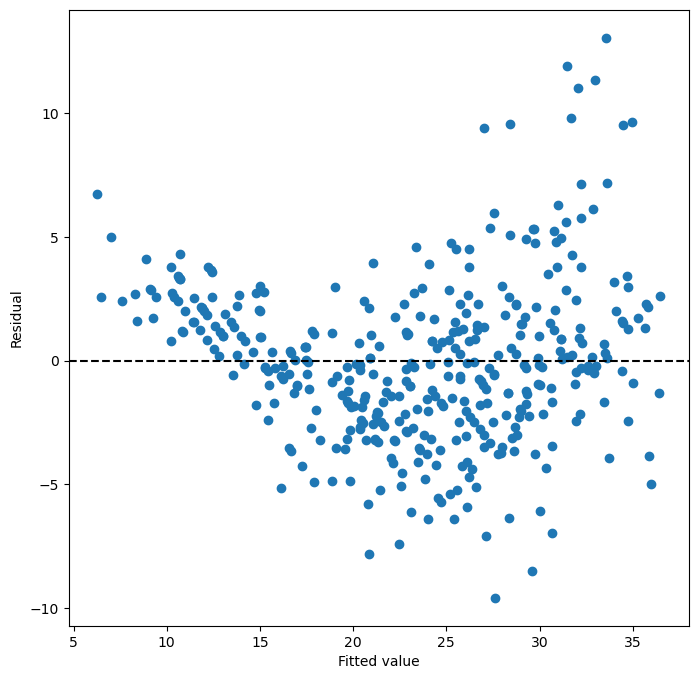

In [109]:
# Create a residual plot
residual_plot(results1)

Again, the residual plot has a funnel-like shape, suggesting that the relationship between this combination of predictors and the response is probably non-linear.

Point with max leverage:  13


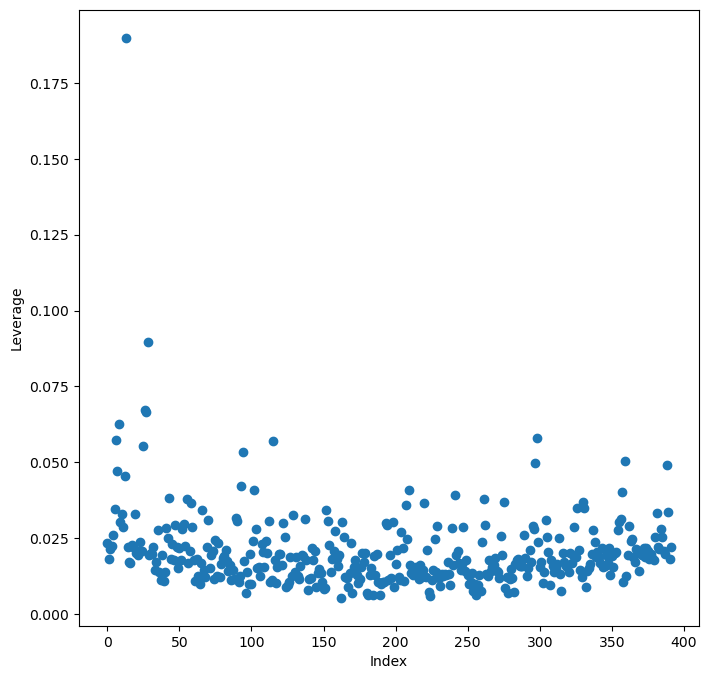

In [117]:
# Plot the leverage of each datapoint on our predictor:
leverage_plot(results1)

The point at index 13 has a particularly high leverage (i.e. has an unusual set of predictor values).

Fit some models with interactions as described in the lab. Do
any interactions appear to be statistically signifcant?

Let's try a model with interaction terms for `weight`,`displacement` and `weight`,`cylinders`.

In [69]:
allvars = list(Auto.columns.drop(['mpg', 'name']))
y = Auto['mpg']
final = allvars + [('weight', 'displacement'),
('weight', 'cylinders')]
X = MS(final).fit_transform(Auto)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     258.1
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          2.18e-156
Time:                        16:06:46   Log-Likelihood:                -977.54
No. Observations:                 392   AIC:                             1975.
Df Residuals:                     382   BIC:                             2015.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept              -6.3601      6.038     -1.053      0.293     -18.232       5.512
cylinders               0.4592      1.519      0.302      0.763      -2.527       3.445
displacement           -0.0732      0.024     -3.083      0.002      -0.120      -0.027
horsepower             -0.0327      0.012     -2.640      0.009      -0.057      -0.008
weight                 -0.0103      0.002     -6.320      0.000      -0.014      -0.007
acceleration            0.0651      0.089      0.735      0.463      -0.109       0.239
year                    0.7851      0.046     17.223      0.000       0.695       0.875
origin                  0.5530      0.265      2.088      0.037       0.032       1.074
weight:displacement  2.401e-05   6.15e-06      3.902      0.000    1.19e-05    3.61e-05
weight:cylinders       -0.0001      0.000     -0.229      0.819      -0.001       0.001
==============================================================================
Omnibus:                       46.914   Durbin-Watson:                   1.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.974
Skew:                           0.646   Prob(JB):                     1.95e-22
Kurtosis:                       5.110   Cond. No.                     3.45e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [68]:
X

,intercept,cylinders,displacement,horsepower,weight,acceleration,year,origin,weight:displacement,weight:cylinders
0,1.0,8,307.0,130,3504,12.0,70,1,1075728.0,28032.0
1,1.0,8,350.0,165,3693,11.5,70,1,1292550.0,29544.0
2,1.0,8,318.0,150,3436,11.0,70,1,1092648.0,27488.0
3,1.0,8,304.0,150,3433,12.0,70,1,1043632.0,27464.0
4,1.0,8,302.0,140,3449,10.5,70,1,1041598.0,27592.0
...,...,...,...,...,...,...,...,...,...,...
387,1.0,4,140.0,86,2790,15.6,82,1,390600.0,11160.0
388,1.0,4,97.0,52,2130,24.6,82,2,206610.0,8520.0
389,1.0,4,135.0,84,2295,11.6,82,1,309825.0,9180.0
390,1.0,4,120.0,79,2625,18.6,82,1,315000.0,10500.0


Try a few different transformations of the variables, such as:

$$
\log(X)
$$

$$
\sqrt{X}
$$

$$
X^2
$$

Comment on your findings.


From the scatterplot matrix above, it looks as though `displacement`, `horsepower` and `weight` might have non-linear relationship with mpg, so let's try a model with just `weight`.

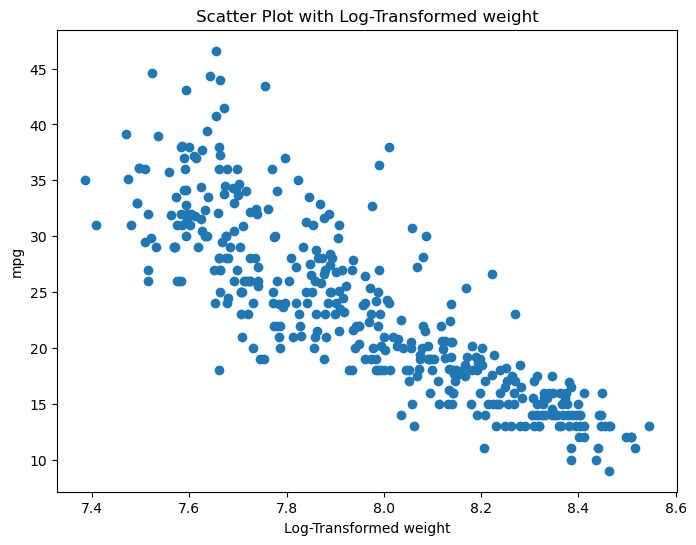

In [85]:
# Apply log transform to weight
log_transformed_weight = np.log(Auto['weight'])

# Create the plot using matplotlib
plt.figure(figsize=(8, 6))
plt.scatter(log_transformed_weight, Auto['mpg'])
plt.title('Scatter Plot with Log-Transformed weight')
plt.xlabel('Log-Transformed weight')
plt.ylabel('mpg')
plt.show()

In [79]:
# Add log_weight to Auto
Auto['log_weight'] = np.log(Auto['weight'])

In [82]:
vars = list(Auto.columns.drop(['mpg', 'name', 'weight', 'displacement', 'horsepower', 'cylinders']))
y = Auto['mpg']
X = MS(vars).fit_transform(Auto)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     514.4
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          2.06e-153
Time:                        16:33:34   Log-Likelihood:                -999.91
No. Observations:                 392   AIC:                             2010.
Df Residuals:                     387   BIC:                             2030.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept      113.0460      7.846     14.408      0.000      97.620     128.472
acceleration     0.0788      0.064      1.234      0.218      -0.047       0.204
year             0.7684      0.046     16.829      0.000       0.679       0.858
origin           0.7644      0.247      3.091      0.002       0.278       1.251
log_weight     -18.8981      0.764    -24.728      0.000     -20.401     -17.396
==============================================================================
Omnibus:                       48.875   Durbin-Watson:                   1.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.674
Skew:                           0.670   Prob(JB):                     1.86e-23
Kurtosis:                       5.148   Cond. No.                     3.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's compare this with a model which uses just `weight`:

In [83]:
vars = list(Auto.columns.drop(['mpg', 'name', 'log_weight', 'displacement', 'horsepower', 'cylinders']))
y = Auto['mpg']
X = MS(vars).fit_transform(Auto)
model2 = sm.OLS(y, X)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     435.1
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          9.72e-142
Time:                        16:33:37   Log-Likelihood:                -1027.2
No. Observations:                 392   AIC:                             2064.
Df Residuals:                     387   BIC:                             2084.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept      -18.7949      4.051     -4.639      0.000     -26.760     -10.829
weight          -0.0059      0.000    -21.951      0.000      -0.006      -0.005
acceleration     0.0797      0.069      1.159      0.247      -0.056       0.215
year             0.7465      0.049     15.181      0.000       0.650       0.843
origin           1.1633      0.259      4.487      0.000       0.654       1.673
==============================================================================
Omnibus:                       35.211   Durbin-Watson:                   1.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.142
Skew:                           0.555   Prob(JB):                     3.21e-14
Kurtosis:                       4.604   Cond. No.                     7.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

10. This question should be answered using the `Carseats` data set.

In [119]:
Carseats = load_data('Carseats')
Carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [120]:
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


Fit a multiple regression model to predict `Sales` using `Price`, `Urban`, and `US`.

In [124]:
vars = ['Price', 'Urban', 'US']
y = Carseats['Sales']
X = MS(vars).fit_transform(Carseats)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Fri, 18 Aug 2023   Prob (F-statistic):           2.39e-23
Time:                        10:52:15   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.0435      0.651     20.036      0.000      11.764      14.323
Price         -0.0545      0.005    -10.389      0.000      -0.065      -0.044
Urban[Yes]    -0.0219      0.272     -0.081      0.936      -0.556       0.512
US[Yes]        1.2006      0.259      4.635      0.000       0.691       1.710
==============================================================================
Omnibus:                        0.676   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.758
Skew:                           0.093   Prob(JB):                        0.684
Kurtosis:                       2.897   Cond. No.                         628.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation:

`Urban` - this coefficient is not statistically significant, suggesting that there is no relationship between this variable and sales.

`US` - Qualitative variable with positive relationship. This means that when the observation is US, there will be a tendency for higher sales values. On average, if a store is located in the US, it will sell approximately 1201 more units.

`Price` - Quantitative variable with negative relationship. This means that the higher the prices, the lower the sales. On average, for every dollar that the price increases sales will drop by about 55 units.

From the p-values in the summary above, we can reject the null hypothesis for the `intercept`, `US` and `Price`, but not for `Urban`.

On this basis, we fit a smaller model for which there is evidence of association with the outcome:

In [126]:
vars = ['Price', 'US']
y = Carseats['Sales']
X = MS(vars).fit_transform(Carseats)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Fri, 18 Aug 2023   Prob (F-statistic):           2.66e-24
Time:                        11:07:08   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.0308      0.631     20.652      0.000      11.790      14.271
Price         -0.0545      0.005    -10.416      0.000      -0.065      -0.044
US[Yes]        1.1996      0.258      4.641      0.000       0.692       1.708
==============================================================================
Omnibus:                        0.666   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.749
Skew:                           0.092   Prob(JB):                        0.688
Kurtosis:                       2.895   Cond. No.                         607.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To compare how well the models fit, we can consider the value of `R-squared`. `R-squared` is the coefficient of determination. The coefficient of determination measures how much of the variance can be explained by the independent variables considered in the model.

Since `R-squared` has the same value, namely 0.239, for both models we can conclude that the smaller model is better, since it uses fewer variables. This can also be seen in the value of the `adjusted R-squared` which is smaller for the smaller model (`adjusted R-squared` penalizes the inclusion of unnecessary variables that might not improve the model's performance, helping to guard against overfitting). However, neither model fits the data very well given the low value of `R-squared`.

What evidence of outliers and high-leverage observations is there?

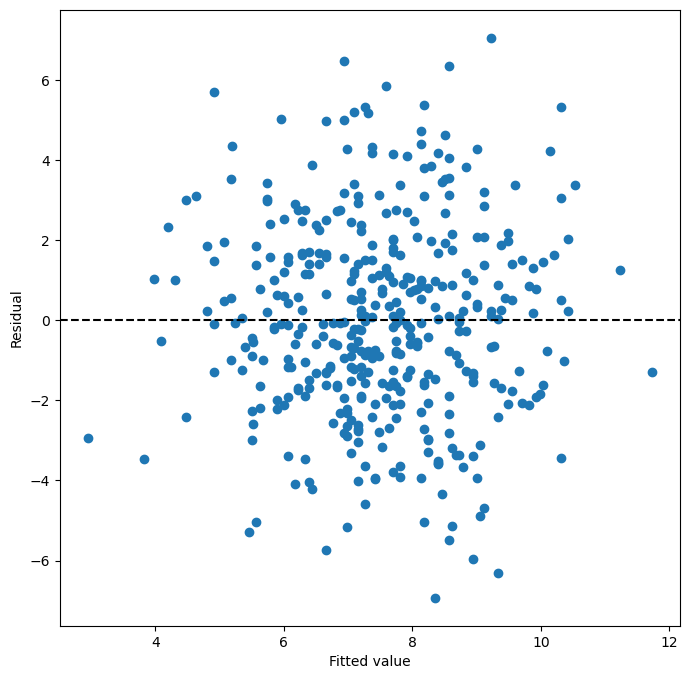

In [127]:
# Create a residual plot
residual_plot(results)

Point with max leverage:  42


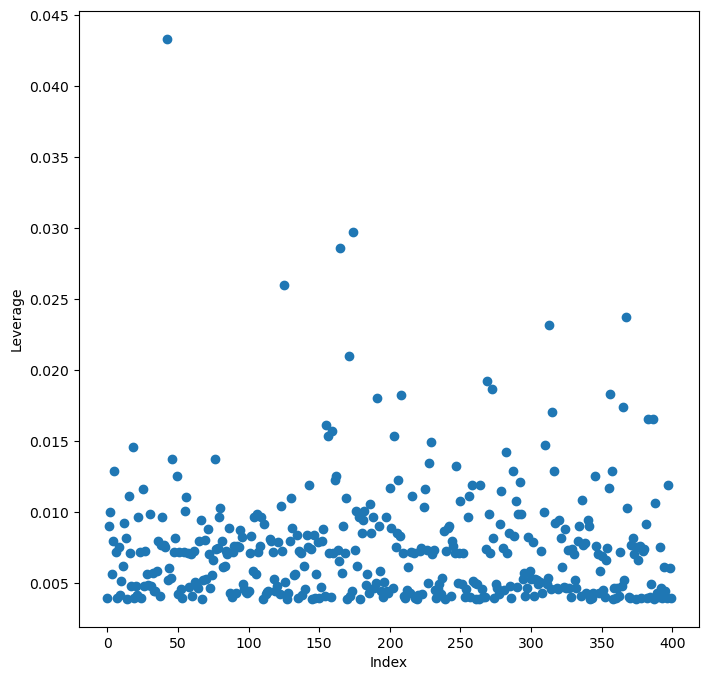

In [128]:
# Create a leverage plot
leverage_plot(results)

There are no outliers, but there are some high leverage points although likely not very influential.

15. This problem involves the `Boston` data set, which we saw in the lab for this chapter. We will now try to predict per capita crime rate using the other variables in this data set.

In [129]:
Boston = load_data('Boston')
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [134]:
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [156]:
# Summarise simple linear regression models for each predictor
predictors = list(Boston.columns.drop('crim'))
y = Boston['crim']

# Create an empty list to store results
results_data = []
for predictor in predictors:
    X = MS([predictor]).fit_transform(Boston)
    model = sm.OLS(y, X)
    results = model.fit()
    predictor_data = {
        'Predictor': predictor,
        'Coefficient': results.params[predictor],
        'P-Value': results.pvalues[predictor],
        'Fitted-Values': results.fittedvalues
    }
    results_data.append(predictor_data)

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results_data)
results_df

,Predictor,Coefficient,P-Value,Fitted-Values
0,zn,-0.073935,5.506472e-06,0 3.122864 1 4.453694 2 4.45369...
1,indus,0.509776,1.450349e-21,0 -0.886159 1 1.540376 2 1.54037...
2,chas,-1.892777,2.094345e-01,0 3.744447 1 3.744447 2 3.74444...
3,nox,31.248531,3.751739e-23,0 3.091827 1 0.935679 2 0.93567...
4,rm,-2.684051,6.346703e-07,0 2.834167 1 3.247511 2 1.19689...
5,age,0.107786,2.854869e-16,0 3.249756 1 4.726427 2 2.80783...
6,dis,-1.550902,8.519949e-19,0 3.156074 1 1.795778 2 1.79577...
7,rad,0.617911,2.693844e-56,0 -1.669249 1 -1.051338 2 -1.05133...
8,tax,0.029742,2.357127e-47,0 0.275338 1 -1.330744 2 -1.33074...
9,ptratio,1.151983,2.942922e-11,0 -0.021597 1 2.858360 2 2.85836...


The list above indicates that every predictor except `chas` has a statistically significant association with `crim` at the 5% significance level. We can plot each predictor against the response with the regression line from the fit:

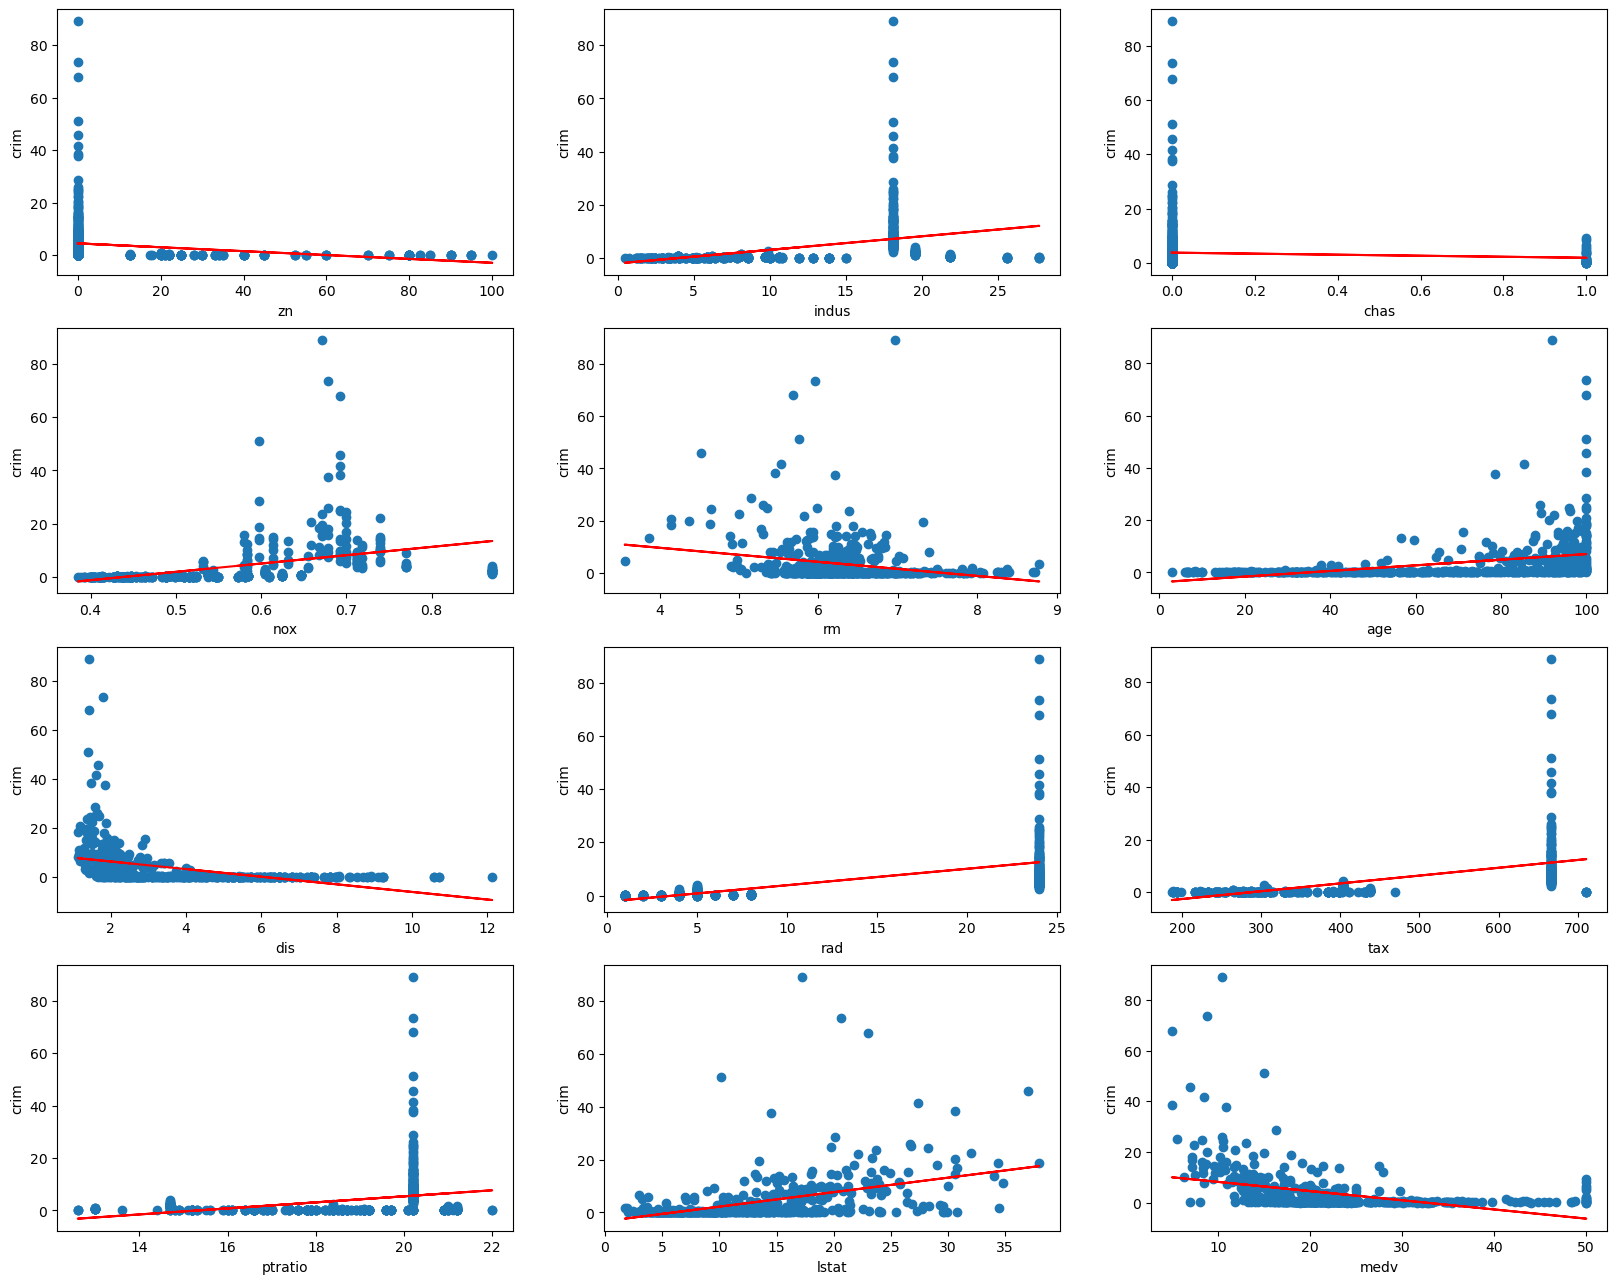

In [168]:
plt.figure(figsize=(20, 20))

for i, predictor in enumerate(results_data):
    plt.subplot(5,3,i + 1)
    plt.xlabel(predictor['Predictor'])
    plt.ylabel('crim')
    plt.scatter(Boston[predictor['Predictor']], Boston['crim'])
    plt.plot(Boston[predictor['Predictor']], predictor['Fitted-Values'], color='red')

We can fit a multiple linear regression using all predictors:

In [170]:
X = MS(predictors).fit_transform(Boston)
model2 = sm.OLS(y, X)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   crim   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     33.52
Date:                Fri, 18 Aug 2023   Prob (F-statistic):           2.03e-56
Time:                        12:19:23   Log-Likelihood:                -1655.4
No. Observations:                 506   AIC:                             3337.
Df Residuals:                     493   BIC:                             3392.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.7784      7.082      1.946      0.052      -0.136      27.693
zn             0.0457      0.019      2.433      0.015       0.009       0.083
indus         -0.0584      0.084     -0.698      0.486      -0.223       0.106
chas          -0.8254      1.183     -0.697      0.486      -3.150       1.500
nox           -9.9576      5.290     -1.882      0.060     -20.351       0.436
rm             0.6289      0.607      1.036      0.301      -0.564       1.822
age           -0.0008      0.018     -0.047      0.962      -0.036       0.034
dis           -1.0122      0.282     -3.584      0.000      -1.567      -0.457
rad            0.6125      0.088      6.997      0.000       0.440       0.784
tax           -0.0038      0.005     -0.730      0.466      -0.014       0.006
ptratio       -0.3041      0.186     -1.632      0.103      -0.670       0.062
lstat          0.1388      0.076      1.833      0.067      -0.010       0.288
medv          -0.2201      0.060     -3.678      0.000      -0.338      -0.103
==============================================================================
Omnibus:                      663.436   Durbin-Watson:                   1.516
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80856.852
Skew:                           6.579   Prob(JB):                         0.00
Kurtosis:                      63.514   Cond. No.                     1.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In the multiple model, `zn`, `dis` `rad` and `medv` all have a statistically significant association with the response.